Standard library imports.

In [1]:
import sys

Related third party imports.

In [2]:
from numpy import array, empty

import matplotlib.pyplot as plt

Variaveis globais

In [3]:
# Parametros da exibicao dos graficos
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['axes.titlesize'] = 30

# Do item 1
prec = 1e-7    # precisao da solucao
nmax = 8    # Numero maximo de iteracoes do algoritmo de Bulirsch-Stoer
a = .0    # Inicio do intervalo de integracao
H = 1.    # Tamanho sugerido do passo de integracao

# Do item 2
prec_b = 1e-2

Constantes

In [4]:
# Do item 1
B, K = .5, 1./14.

# Do item 2
CAPACIDADE, ATENDER = 4e-4, 5e-2

# Item 1

Condicoes iniciais

In [5]:
i_0, r_0 = 1e-6, 0
s_0 = 1 - i_0 - r_0

Equacoes de diferenca

In [6]:
def f(r,t):
    s, i = r[:2]
    fs, fr = -B*s*i, K*i
    fi = -fs-fr
    return array([fs,fi,fr],float)

Metodo de integracao

In [7]:
def passo_mbs_indiv(f,r,t,H,prec,nmax):
    # Calcula um passo no metodo de Bulirsch-Stoer. Caso se atinjam
    # 'nmax' iteracoes sem convergencia, retorna a informacao
    # Inicializamos com um passo do metodo do ponto medio modificado
    # A matriz R1 armazena a primeira linha da tabela de extrapolacao.
    # Por agora, essa linha contem apenas a estimativa do metodo do
    # ponto medio modificado para a solucao no final do intervalo.
    converge = False
    n = 1
    y = r + 0.5*H*f(r,t)
    x = r + H*f(y,t+0.5*H)
    R1 = empty([1,r.shape[0]],float)
    R1[0] = 0.5*(y + x + 0.5*H*f(x,t+H))
    # Agora fazemos um laco aumentando o valor de n ate que a precisao
    # seja atingida.
    for n in range(2,nmax+1):
        h = H/n
        # Metodo do ponto medio modificado
        y = r + 0.5*h*f(r,t)
        x = r + h*f(y,t+0.5*h)
        for i in range(n-1):
            y += h*f(x,t+(i+1.0)*h)
            x += h*f(y,t+(i+1.5)*h)
        # Calculando as estimativas por extrapolacao.
        # As matrizes R1 e R2 armazenam a penultima e a ultima
        # linhas mais recentes da tabela
        R2 = empty([n,r.shape[0]],float)
        R2[0] = 0.5*(y + x + 0.5*h*f(x,t+h))
        for m in range(1,n):
            epsilon = (R2[m-1]-R1[m-1])/((n/(n-1))**(2*m)-1)
            R2[m] = R2[m-1] + epsilon
        erro = max(abs(epsilon[0]),abs(epsilon[1]),abs(epsilon[2]))
        if erro <= H*prec:
            converge = True
            break
        R1 = R2
    # Fazemos r igual a estimativa mais precisa de que dispomos
    r = R2[n-1]
    return converge, r  # Retornamos o NOVO VALOR de r

In [8]:
def passo_mbs_adapt(f,H,prec,nmax,r_lista,t_lista):
    # Calcula um passo no metodo de Bulirsch-Stoer adaptativo.
    # Esta funcao nao retorna nenhum valor, mas apenas atualiza as listas
    # de t e de r ao atingir convergencia em ate 'nmax' iteracoes
    r = r_lista[-1]
    t = t_lista[-1]
    converge, r = passo_mbs_indiv(f,r,t,H,prec,nmax)
    if converge == False: # Se nao houve convergencia, divida o passo por 2
        passo_mbs_adapt(f,H/2,prec,nmax,r_lista,t_lista)
    else:
        t_lista.append(t+H)
        r_lista.append(r)

In [9]:
def integ_mbs_adapt(f,r_a,a,H,prec,nmax,r_lista,t_lista):
    # Esta funcao percorre o intervalo de integracao, determinando os
    # valores de r e t com passo maximo de tamanho H, que e subdividido
    # caso nao se atinja a precisao requerida em ate 'nmax' iteracoes
    # do algoritmo de Bulirsch-Stoer. A funcao nao retorna um valor,
    # mas atualiza as listas de r e t.
    t = a
    t_lista.append(t)    # Registramos o valor inicial de t
    r_lista.append(r_a)  # Registramos o valor inicial de r
    while r_lista[-1][1] > prec:
        passo_mbs_adapt(f,H,prec,nmax,r_lista,t_lista)
        t = t_lista[-1]  # Atualizamos t para o ultimo valor calculado

Integrar

In [10]:
r_a = array([s_0, i_0, r_0],float)    # Condicao inicial
r_lista, t_lista = [], []
integ_mbs_adapt(f,r_a,a,H,prec,nmax,r_lista,t_lista)

Para garantir que os resultados sao confiaveis utilizei o metodo de
Bulirsch-Stoer, pois sabemos que a quantidade
$$
    s(t) + i(t) + r(t) = 1
$$
eh consevada em t.

E observamos que para cada passo $ | s \left( t \right) + i \left( t \right) + r \left( t \right) -1| \leq prec.$

In [11]:
# Lista booleana dos passos que |s(t)+i(t)+r(t)-1|>prec 
n_lista = [abs(1-arr.sum())>prec for arr in r_lista]
print('Total de passos em que |s(t)+i(t)+r(t)-1|>prec:',sum(n_lista))

Total de passos em que |s(t)+i(t)+r(t)-1|>prec: 0


In [12]:
inf_lista = [r[1] for r in r_lista]
rec_lista = [r[2] for r in r_lista]

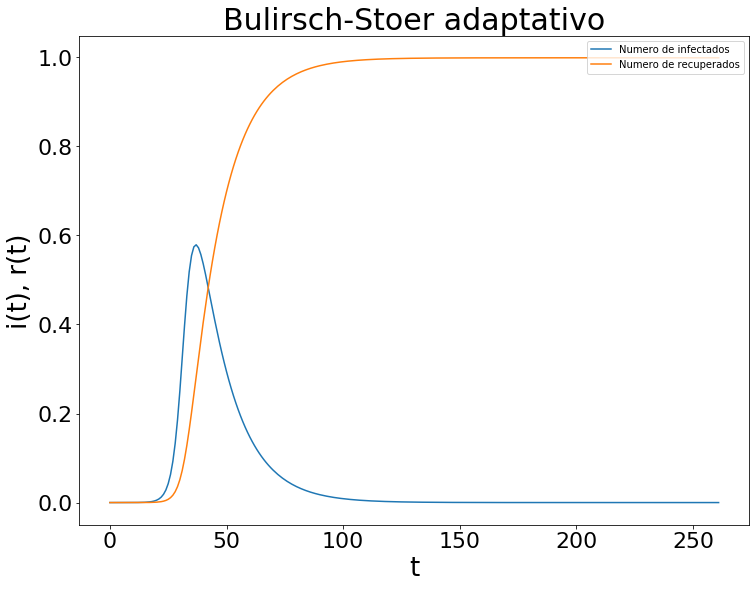

In [13]:
plt.figure(figsize=(12,9))
plt.title("Bulirsch-Stoer adaptativo")
plt.xlabel("t")
plt.ylabel("i(t), r(t)")
plt.plot(t_lista,inf_lista,label="Numero de infectados")
plt.plot(t_lista,rec_lista,label="Numero de recuperados")
plt.legend(loc='upper right')
plt.show()

Em primeiro momento nao ha recuperados na populacao, assim os 
contaminados aumentam. Conforme a doenca se espalha, o numero de
suscetiveis diminui freando o crescimento dos infectados ate que a
velocidade em que se curam fica maior. A partir deste momento, a
quantidade de infectados diminui com seu fator de decaimento exponecial
se tornando mais predominante.

# Item 2

Solucao via metodo da bisseccao (busca binaria)

In [14]:
b1 = 1e-2   # Palpite de um B menor que o desejado
r_lista1, t_lista1 = [], []
B = b1
integ_mbs_adapt(f,r_a,a,H,prec,nmax,r_lista1,t_lista1)

b2 = 1e1   # Palpite de um B maior que o desejado
r_lista2, t_lista2 = [], []
B = b2
integ_mbs_adapt(f,r_a,a,H,prec,nmax,r_lista2,t_lista2)

In [15]:
atendimentos_lista1 = [r[1]*ATENDER for r in r_lista1]
atendimentos_lista2 = [r[1]*ATENDER for r in r_lista2]

In [16]:
altura1 = max(atendimentos_lista1) - CAPACIDADE
altura2 = max(atendimentos_lista2) - CAPACIDADE
if (altura1*altura2 > 0):
    sys.exit("Alturas relativas com mesmo sinal. Modifique Bs.")
while abs(b2-b1) > prec_b:
    bp = (b1+b2)/2                           # Media entre 'b1' e 'b2'
    r_listap, t_listap = [], []
    B = bp
    integ_mbs_adapt(f,r_a,a,H,prec,nmax,r_listap,t_listap)
    
    atendimentos_listap = [r[1]*ATENDER for r in r_listap]

    alturap = max(atendimentos_listap) - CAPACIDADE
    if (altura1 * alturap) > 0:              # Altura final menor que desejada? 
        b1, altura1 = bp, alturap            # Sim; aumentamos o palpite 'b1'
    else:
        b2, altura2 = bp, alturap            # Nao; diminuimos o palpite 'b2'
b = round((b1+b2)/2, 3)       # Resultado final do calculo

print(
    '''O maximo valor de b para "achatar a curva" de infectados de tal forma a
nunca ultrapassar a capacidade de atendimento eh''',
    b)

O maximo valor de b para "achatar a curva" de infectados de tal forma a
nunca ultrapassar a capacidade de atendimento eh 0.083


In [17]:
r_listap, t_listap = [], []
B = b
integ_mbs_adapt(f,r_a,a,H,prec,nmax,r_listap,t_listap)

In [18]:
print(f'A fracao maxima de recuperados ao final da pandemia para b = {B}:')
print(round(r_listap[-1][2], 3))

A fracao maxima de recuperados ao final da pandemia para b = 0.083:
0.265


In [19]:
print('A fracao maxima de recuperados ao final da pandemia para b = 1/2:')
print(round(rec_lista[-1], 3))

A fracao maxima de recuperados ao final da pandemia para b = 1/2:
0.999


Eh interessante observar que para sair do regime em que a doenca nao
satura o sistema de atendimento precisamos sair tambem do regime em que
a pandemia atinge toda a populacao, para o K dado.

In [20]:
print(
    '''A quantidade de dias que um individuo infectado deve permanecer sem ter
contatos com individuos suscetiveis eh aprox.''',
    round(1/b),
    'dias.')

A quantidade de dias que um individuo infectado deve permanecer sem ter
contatos com individuos suscetiveis eh aprox. 12 dias.
